# Spatial random forest for flood prediction
Outcome variable: `floodfrac` represents presence/absence of flood in pixel (slightly misleading name.)


Slightly dodgy, but modified this file to get rid of the annoying ImportError: Numba needs NumPy 1.21 or less. <br> _'~/miniconda3/envs/hybridmodels-modelbuild/lib/python3.10/site-packages/numba/__init__.py'_ <br>
changed line 139 from ```elif numpy_version > (1, 21):``` to ```elif numpy_version > (1, 23):```
Seems okay so far...

In [7]:
# settings
import model_utils

RUNNAME = ''  # leave blank for run not being saved
LOGTHISRUN = False

TO_REMOVE = []  # for trialing removing features
NORM_TYPE = None
MAX_DEPTH = None  # if I wanna change it for plotting trees
TEST_EVENTS = model_utils.test_events

# STORMS = ['roanu', 'gombe']
CONDITION = None  # lambda row: any(event in gdf.reset_index().loc[0, 'event'] for event in STORMS)
# TEST_EVENTS = ['gombe_mossuril_0',
#                'emnati_madagascar_3_0',
#                'batsirai_menabe_0',
#                'noul_vietnam_0',
#                'roanu_satkania_0',
#                'fani_eastindia_0_2',
#                'fani_eastindia_0_3',
#                'irma_jacksonvillesouth_1']

In [8]:
# general imports
from os.path import join
from os import mkdir
import joblib
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import logging
from datetime import datetime

# machine learning imports
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix as cm
from sklearn.inspection import permutation_importance

# plotting imports
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import FuncFormatter

# helper function imports
from importlib import reload
import model_utils
import data_utils
import viz_utils
from viz_utils import soge_colours, add_feature_label, format_event_string

# fix for local issue with multiple proj installations
import pyproj
pyproj.datadir.get_data_dir()  # '/Users/alison/miniconda3/share/proj'
pyproj.datadir.set_data_dir('/Users/alison/miniconda3/envs/hybridmodels-modelbuild/share/proj')
pyproj.datadir.get_data_dir()

# ignore annoying FutureWarning in RandomForest cell
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.rcParams["font.family"] = "Times New Roman"

# set up the environment
wd = join("..", "data")
imdir = join(wd, 'images')
logdir = join("logfiles")

# folder for image results of this run
runtime = datetime.now()
try:
    mkdir(join(imdir, 'rf_spatial', RUNNAME))
except Exception as e:
    print(e)
    


[Errno 17] File exists: '../data/images/rf_spatial/'


## Load  data and visualise

In [9]:
reload(model_utils)
gdf_orig = model_utils.load_spatial_data(wd)  # load gdfs with all features as one big gdf

In [10]:
# initial summary (check everything looks right)
print(f"Unique events: {gdf_orig['event'].nunique()}")
# count number of nulls per feature and event
for col in gdf_orig.columns:
    if gdf_orig[col].isnull().sum() > 0:
        num_nulls = gdf_orig[col].isnull().sum()
        events_with_null = [*gdf_orig[gdf_orig[col].isnull()]['event'].unique()]
        print(f"{num_nulls} null values for {col} in", *events_with_null)

Unique events: 59
64 null values for elevation in roanu_chittagong_0
64 null values for evi_anom in roanu_chittagong_0
12352 null values for soiltemp2 in irma_tampasouth_0 roanu_chittagong_0 irma_tampanorth_0 gombe_mossuril_0
12352 null values for soiltemp2_anom in irma_tampasouth_0 roanu_chittagong_0 irma_tampanorth_0 gombe_mossuril_0
64 null values for precip in roanu_chittagong_0
64 null values for evi in roanu_chittagong_0
237568 null values for lulc__nan in emnati_madagascar_5_0 irma_tampasouth_0 irma_jacksonvillesouth_0 idai_beira_0 batsirai_menabe_0 fani_eastindia_0_6 fani_eastindia_0_7 batsirai_menabe_1 noul_vietnam_0 batsirai_mananjary_0 goni_tiwi_0 roanu_satkania_0 gombe_mossuril_4 irma_jacksonvillesouth_1 emnati_madagascar_7_0 irma_tampasouth_1 batsirai_tsiribihina_0 goni_bato_0 irma_tampanorth_2 fani_eastindia_0_0 roanu_barguna_0 gombe_mossuril_3 emnati_madagascar_3_0 roanu_lalmohan_0 megi_westernvisayas_1 roanu_lalmohan_1 megi_westernvisayas_0 gombe_mossuril_2 roanu_bargun

In [11]:
# option subset by a continent (can change to ocean etc. also)
if False:
    datasets = pd.read_csv(join(wd, 'csvs', 'current_datasets.csv'))[['event', 'region', 'continent']]
    datasets = datasets[datasets['continent'] == 'africa']
    events_list = [*datasets[['event', 'region']].agg('_'.join, axis=1)]
    
    TEST_EVENTS = [event for event in TEST_EVENTS if '_'.join(event.split('_')[:2]) in events_list]

    gdf['event_region'] = gdf['event'].apply(lambda x: '_'.join(x.split('_')[:-1]))
    gdf = gdf[gdf['event_region'].isin(events_list)]
    gdf = gdf.drop('event_region', axis=1)

## Process data
Process features for machine learning - order of functions matters here.

In [12]:
reload(model_utils)
reload(data_utils)

SEED = 1

gdf = gdf_orig.copy(deep=True)  # if need to reset gdf
print(f"Initial length of dataframe: {len(gdf):,} grid cells.\n")

# apply any conditions to the data
print('Applying custom conditions...')
if CONDITION:
    gdf = gdf[gdf.apply(CONDITION, axis=1)]

print('Removing features...')
# define columns and remove features being exluded
notes = []
columns = [*gdf.columns]
gdf, columns, notes = model_utils.remove_feature(gdf, TO_REMOVE, columns, notes)
                 
# define predictive feature columns             
features = columns.copy()
features.remove('geometry')
features.remove('floodfrac')
features.remove('event')
nfeatures = len(features)

# sort binary and continuous features
features_binary, features_continuous = data_utils.split_features_binary_continuous(data_utils.binary_keywords, features)

# summarise LULC columns
gdf, columns, features_binary, features_continuous, nfeatures, notes = model_utils.summarise_lulc(gdf, columns, features_binary, features_continuous, notes)
features = features_binary + features_continuous
print(f"After summarising LULC length: {len(gdf):,} grid cells.\n")

# binarise binary features
for feature in features_binary:
    gdf[feature] = gdf[feature].apply(lambda x: 1 if x > data_utils.floodthresh else 0).astype(int)

# remove permanent water cells
print(f"\nBefore removing permanent water: {len(gdf):,}")
gdf = gdf[gdf['dist_pw'] > 0]
print(f"After removing permanent water: {len(gdf):,}\n")
notes.append('removed permanent water grid cells')

# remove exclusion mask cells
print(f"\nBefore exclusion mask: {len(gdf):,}")
gdf.loc[:, 'exclusion_mask'] = gdf['exclusion_mask'].apply(lambda x: 0 if np.isnan(x) else x)
gdf = gdf[gdf['exclusion_mask'] != 1]
notes.append('removed exclusion mask cells')
print(f"After exclusion mask: {len(gdf):,}\n")

# remove rows containing NaN (for now)
print(f"Columns with null rows {gdf.columns[gdf.isnull().any()].tolist()}")
print(f"Number of null rows: {sum(gdf.isnull().any(axis=1))}")
print(f"Events with null rows: {[*gdf[gdf.isnull().any(axis=1)].event.unique()]}\n")
print(f"Before dropping NaN rows: {len(gdf):,}")
gdf = gdf.dropna()
print(f"After dropping NaN rows: {len(gdf):,}")

# normalise
if NORM_TYPE is None:
    gdf_normalised = gdf.copy()
    for feature in features_continuous:
        gdf_normalised = model_utils.normalise_feature(gdf_normalised, feature)
    notes.append(f"Normalised all {features_continuous}.")
else:
    gdf_normalised = model_utils.normalise_per_subset(gdf, features_continuous, NORM_TYPE)
    notes.append(f"Normalised all {features_continuous} on a per-{NORM_TYPE} basis")

gdf_normalised['floodfrac'] = gdf_normalised['floodfrac'].astype(int)

# finally, make sure only use final features for model
features = model_utils.model_features
columns = features + ['event', 'floodfrac', 'geometry']
feature_binary, feature_continuous = data_utils.split_features_binary_continuous(data_utils.binary_keywords, features)
gdf_normalised = gdf_normalised[columns]

# remove test events from data for testing and plotting later
gdf_test_unseen = gdf_normalised[gdf_normalised['event'].apply(lambda x: x in TEST_EVENTS)]
gdf_normalised = gdf_normalised[~(gdf_normalised['event'].apply(lambda x: x in TEST_EVENTS))]
gdf_test_unseen = gpd.overlay(gdf_test_unseen, gdf_normalised, how='difference')  # remove any overlapping bits

Initial length of dataframe: 241,664 grid cells.

Applying custom conditions...
Removing features...
After summarising LULC length: 241,664 grid cells.


Before removing permanent water: 241,664
After removing permanent water: 96,524


Before exclusion mask: 96,524
After exclusion mask: 72,858

Columns with null rows ['soiltemp2', 'soiltemp2_anom']
Number of null rows: 4418
Events with null rows: ['irma_tampasouth_0', 'irma_tampanorth_0', 'gombe_mossuril_0']

Before dropping NaN rows: 72,858
After dropping NaN rows: 68,440


In [13]:
# random undersampling of training set
print(f"Before undersampling length: {len(gdf_normalised):,}")
print(f"Number of ones: {gdf_normalised['floodfrac'].sum():,}")
print(f"Number of zeros: {gdf_normalised['floodfrac'].count() - gdf_normalised['floodfrac'].sum():,}")

n = len(gdf_normalised)
n1 = gdf_normalised['floodfrac'].sum()
n0 = n - n1
gdf_normalised, notes = model_utils.random_undersample(gdf_normalised, n0, n1, notes, columns, SEED)

gdf_normalised = gdf_normalised.replace(np.nan, 0.)
gdf_normalised['floodfrac'] = gdf_normalised['floodfrac'].astype(int)

print(f"After undersampling length: {len(gdf_normalised):,}")
print(f"Number of ones: {gdf_normalised['floodfrac'].sum():,}")
print(f"Number of zeros: {gdf_normalised['floodfrac'].count() - gdf_normalised['floodfrac'].sum():,}")

print(f"\nNotes:\n-----\n\n{notes}")

Before undersampling length: 60,060
Number of ones: 12,035
Number of zeros: 48,025
After undersampling length: 24,070
Number of ones: 12,035
Number of zeros: 12,035

Notes:
-----

['removed []', 'summarised lulc columns into three categories', 'removed permanent water grid cells', 'removed exclusion mask cells', "Normalised all ['wind_avg', 'dist_pw', 'slope_pw', 'jrc_permwa', 'soilcarbon', 'mangrove_to_pw', 'evi', 'elevation', 'evi_anom', 'evi_spatial', 'elevation_spatial', 'mangrove', 'soilcarbon_to_pw', 'wind_max', 'evi_to_pw', 'mangrove_spatial', 'pressure_min', 'jrc_permwa_spatial', 'precip', 'soiltemp2_anom', 'pressure_avg', 'elevation_to_pw', 'soiltemp2', 'soilcarbon_spatial'].", 'undersampled to same number of flood and non-flood pixels']


# Random Forest: model
## Cross-validate results with the tuned hyperparameters

In [14]:
from tqdm.notebook import tqdm

run_rf = True

if run_rf:
    K = 5  # number of folds to use
    best_params = np.load('best_params_rf.npy', allow_pickle=True).item()
    if MAX_DEPTH is not None:
        best_params['max_depth'] = MAX_DEPTH

    X, y = gdf_normalised[features + ['event', 'geometry']], gdf_normalised['floodfrac']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)
    
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    
    # separate from data for plotting later
    X_train_toview = X_train.copy(deep=True)
    X_test_seen = X_test.copy(deep=True)
    
    X_train = X_train[features]
    X_test = X_test[features]

    cv = KFold(n_splits=K, random_state=SEED, shuffle=True)

    CSIs = []
    TPs = []
    FPs = []
    TNs = []
    FNs = []
    rankings = []

    for train_index, val_index in tqdm(cv.split(X_train)):
        Xf_train, Xf_test = X_train.iloc[train_index, :], X_train.iloc[val_index, :]
        yf_train, yf_test = y_train[train_index], y_train[val_index]

        rf = RandomForestClassifier(random_state=SEED, **best_params)
        rf.fit(Xf_train, yf_train)
        yf_pred = rf.predict(Xf_test)  # sample_weight=None

        confusion_matrix = cm(yf_test, yf_pred)

        if confusion_matrix.shape == (2, 2):
            TP = confusion_matrix[1, 1]
            FP = confusion_matrix[0, 1] #(row, col) = (true, pred)
            FN = confusion_matrix[1, 0]
            TN = confusion_matrix[0, 0]

            TPs.append(TP)
            FPs.append(FP)
            FNs.append(FN)
            TNs.append(TN)

            CSI = TP / (TP + FP + FN)  # critical success index
            CSIs.append(CSI)

        rankings.append(pd.Series(rf.feature_importances_, index=features))
        
print(f"mean of training CSIs: {np.mean(CSIs):.02%}")
print(f"std. of training CSIs: {np.std(CSIs):.02%}")

0it [00:00, ?it/s]

mean of training CSIs: 82.36%
std. of training CSIs: 0.70%


In [15]:
if True:
    if MAX_DEPTH is None:
        joblib.dump(rf, join(wd, 'results', 'unseen test set', 'rf.joblib'))
        pd.DataFrame(features).to_csv(join(wd, 'results', 'unseen test set', 'rf_features.csv'), sep=',',index=False)
    else:
        joblib.dump(rf, join(wd, 'results', 'unseen test set', f'rf_reduced_{MAX_DEPTH}.joblib'))
        pd.DataFrame(features).to_csv(join(wd, 'results', 'unseen test set', f'rf_reduced_{MAX_DEPTH}_features.csv'), sep=',',index=False)


In [16]:
!say done

## Visualise test set in seen location

In [17]:
from matplotlib.colors import ListedColormap
from viz_utils import soge_colours


def get_csi(y_test, y_pred):
    """Return CSI and relevant metrics for two arrays."""
    confusion_matrix = cm(y_test, y_pred)
    if confusion_matrix.shape == (2, 2):
        TP = confusion_matrix[1, 1]
        FP = confusion_matrix[0, 1]  # (row, col) = (true, pred)
        FN = confusion_matrix[1, 0]
        TN = confusion_matrix[0, 0]
        CSI = TP / (TP + FP + FN)    # CSI
        
        return CSI, TP, FP, FN, TN


def confusion_label(y_test, y_pred):
    """Assign confusion label to a (true, predicted) pair."""
    if y_pred + y_test == 2:
        return 'TP'
    elif y_pred + y_test == 0:
        return 'TN'
    elif (y_test == 0) and (y_pred == 1):
        return 'FP'
    elif (y_test == 1) and (y_pred == 0):
        return 'FN'
    else:
        print(f"ISSUE: {y_test}, {y_pred}")
        return ''
    

y_pred = rf.predict(X_test)

/var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_10632/1043158430.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  X_test_event = X_test_event.set_geometry(X_test_event.centroid)
/var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_10632/1043158430.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  X_test_event = X_test_event.set_geometry(X_test_event.centroid)
/var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_10632/1043158430.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  X_test_event = X_test_event.set_geometry(X_test_event.centroid

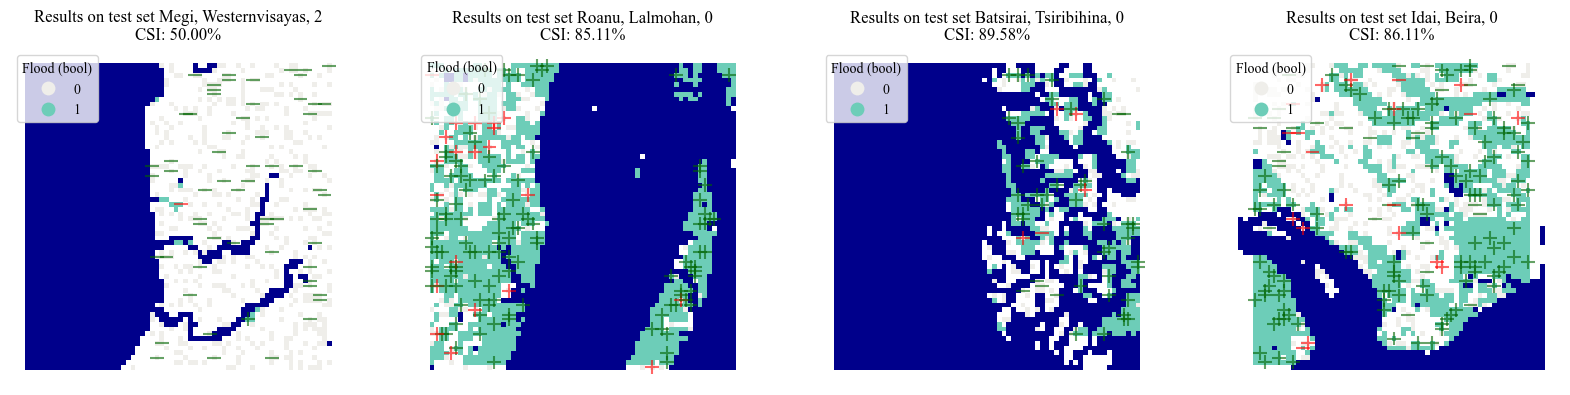

In [18]:
# TODO: add checker to check which events aren't empty

# process data to view single event
X_test_seen[f'flood_true'] = y_test
X_test_seen[f'flood_pred'] = y_pred
X_test_seen['confusion'] = X_test_seen[[f'flood_true', f'flood_pred']].apply(lambda row: confusion_label(row[f'flood_true'], row[f'flood_pred']), axis=1)
events = X_test_seen['event'].unique()

pwater = gdf_orig[gdf_orig['dist_pw'] <= 0]

# loop through events
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, event_to_view in enumerate(events[[2, 3, 4, 5]]):  
    ax = axs[i]
    
    # subset event and calculate csi
    X_test_event = X_test_seen[X_test_seen['event'] == event_to_view]
    X_test_event = X_test_event.set_geometry(X_test_event.centroid)
    csi_test_seen, _, _, _, _ = get_csi(X_test_event[f'flood_true'], X_test_event[f'flood_pred'])

    # set up colors and markerstyles
    bg_cmap = ListedColormap([soge_colours['beige'], soge_colours['light turquoise']])
    markerstyles = {'TP': '+', 'FP': '+', 'TN': '_', 'FN': '_'}
    markercolors = {'TP': 'darkgreen', 'FP': 'red', 'TN': 'darkgreen', 'FN': 'red'}
    
    # get subsets
    X_test_pos = X_test_event[X_test_event.confusion.isin(['TP', 'FP'])]
    X_test_neg = X_test_event[X_test_event.confusion.isin(['TN', 'FN'])]
    bg = gdf_normalised[gdf_normalised['event'] == event_to_view]
    pwater_toplot = pwater[pwater['event'] == event_to_view]

    # plot background and test set points
    bg.plot('floodfrac', categorical=True, cmap=bg_cmap, ax=ax, legend=True,
            legend_kwds={'title': 'Flood (bool)', 'loc': 'upper left'}, zorder=0)
    pwater_toplot.plot(color='darkblue', ax=ax, zorder=1)

    X_test_pos.plot(color=X_test_pos['confusion'].map(markercolors), alpha=0.6,
                    marker='+',  markersize=100, ax=ax, categorical=True, zorder=2)

    X_test_neg.plot(color=X_test_neg['confusion'].map(markercolors), alpha=0.6,
                      marker='_',  markersize=100, ax=ax, categorical=True, zorder=2)
    
    ax.set_title(f"Results on test set {', '.join([x.capitalize() for x in event_to_view.split('_')])}\nCSI: {csi_test_seen:.2%}")
    
for ax in axs:
    # clean up axses
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

fig.savefig(join(imdir, 'rf_spatial', RUNNAME, 'test_set_results.png'), dpi=500, bbox_inches='tight')

In [19]:
!say done

## Feature rankings
1. Impurity-based importance
2. [Permutation-based importances](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance)

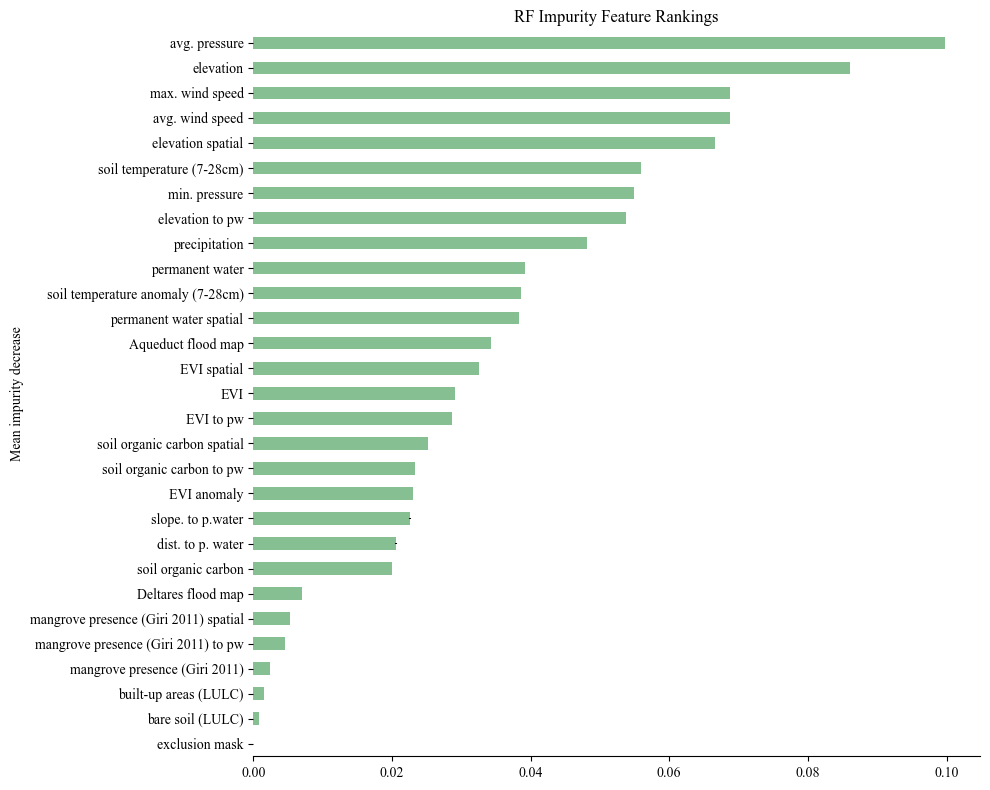

In [20]:
# impurity-based importances
import viz_utils
reload(viz_utils)
runme = True
savefig = True

if runme:
    stds = [np.std([rank[feature] for rank in rankings]) for feature in features]
    means = [np.mean([rank[feature] for rank in rankings]) for feature in features]

    mean_rankings = pd.Series(means, index=features)
    mean_rankings = mean_rankings.rename(index=viz_utils.add_feature_label)
    mean_rankings = mean_rankings.sort_values(ascending=True)

    fig, ax = plt.subplots(figsize=(10, 8))
    mean_rankings.plot.barh(yerr=stds, ax=ax, color='#86bf91')
    ax.set_title("RF Impurity Feature Rankings")
    ax.set_ylabel("Mean impurity decrease")
    fig.tight_layout()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    if savefig:
        fig.savefig(join(imdir, "rf_spatial", RUNNAME, f"RF impurity feature rankings temporal"), dpi=500)

In [21]:
# permutatation importances
run_pis = False

# use critical success index to evaluate model according to scorer
def csi(y_true, y_pred):
    """Critical success index"""
    confusion_matrix = cm(y_true, y_pred)
    TP = confusion_matrix[1, 1]
    FP = confusion_matrix[0, 1]  # (row, col) = (true, pred)
    FN = confusion_matrix[1, 0]
    csi = TP / (TP + FP + FN)  # critical success index
    return csi

def evaluate(model, test_features, test_labels):
    test_predictions = model.predict(test_features)
    csi_val = csi(test_labels, test_predictions)
    print('Model Performance')
    print('CSI = {:0.2f}%.'.format(csi_val))  # should * 100 for next run

    return csi_val

csi_scorer = make_scorer(csi)

if run_pis:
    savefig = True

    best_params = np.load('best_params_rf.npy', allow_pickle=True).item()
    pi = permutation_importance(rf, X_test, y_test, scoring=csi_scorer, random_state=SEED)
    mean_pis = pd.Series(pi.importances_mean, index=features)
    mean_pis = mean_pis.rename(index=add_feature_label)
    mean_pis = mean_pis.sort_values(ascending=True)


    fig, ax = plt.subplots(figsize=(10, 8))
    mean_pis.plot.barh(yerr=pi.importances_std, ax=ax, color='#86bf91')
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean CSI decrease")
    fig.tight_layout()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    if savefig:
        fig.savefig(join(imdir, "rf_spatial", f"RF permutation feature rankings temporal"), dpi=500)
        fig.savefig(join(imdir, "rf_spatial", RUNNAME, f"RF permutation feature rankings temporal"), dpi=500)

In [22]:
! say done

# Evaluate on an unseen subregion

In [23]:
gdf_test_unseen_orig = gdf_test_unseen.copy(deep=True)

In [24]:
# view predictions on the test event
def get_csi(y_test_event, y_pred_event):
    confusion_matrix = cm(y_test_event, y_pred_event)

    TP_test = confusion_matrix[1, 1]
    FP_test = confusion_matrix[0, 1]
    FN_test = confusion_matrix[1, 0]
    TN_test = confusion_matrix[0, 0]

    CSI_test_unseen = TP_test / (TP_test + FP_test + FN_test)  # critical success index
    return CSI_test_unseen

def get_bias(y_test_event, y_pred_event):
    confusion_matrix = cm(y_test_event, y_pred_event)
    TP_test = confusion_matrix[1, 1]
    FP_test = confusion_matrix[0, 1]
    FN_test = confusion_matrix[1, 0]
    TN_test = confusion_matrix[0, 0]
    bias = (TP_test + FP_test ) / (TP_test + FN_test)
    return bias

def get_accuracy(y_test_event, y_pred_event):
    confusion_matrix = cm(y_test_event, y_pred_event)
    TP_test = confusion_matrix[1, 1]
    FP_test = confusion_matrix[0, 1]
    FN_test = confusion_matrix[1, 0]
    TN_test = confusion_matrix[0, 0]
    acc = (TP_test + TN_test ) / (TP_test +FP_test + TN_test + FN_test)
    return acc
    

X_test_event, y_test_event = gdf_test_unseen[features], gdf_test_unseen['floodfrac']
y_pred_event = rf.predict(X_test_event)

CSI_test_unseen = get_csi([*y_test_event], y_pred_event)
bias_test_unseen = get_bias([*y_test_event], y_pred_event)
acc_test_unseen = get_accuracy([*y_test_event], y_pred_event)

In [25]:
y_true_event = gdf_test_unseen['floodfrac'].to_numpy()
gdf_test_unseen['flood_pred'] = y_pred_event
# gdf_test_unseen['floodfrac'] = gdf_test_unseen['floodfrac'].apply(lambda x: 1 if x=='Flood' else 0)
gdf_test_unseen['error_type'] = gdf_test_unseen[['floodfrac', 'flood_pred']].apply(lambda row: confusion_label(row[0], row[1]), axis=1)

# make flood categorical for plotting
gdf_test_unseen['floodfrac'] = gdf_test_unseen['floodfrac'].apply(lambda x: 'No flood' if x==0 else 'Flood')
gdf_test_unseen['flood_pred'] = gdf_test_unseen['flood_pred'].apply(lambda x: 'No flood' if x==0 else 'Flood')

gdf_test_unseen.to_file(join(wd, 'results', 'unseen test set', 'unseen_results.gpkg'))

In [26]:
CSIs_test_unseen = []
for event in TEST_EVENTS:
    if event in [*gdf.event.unique()]:
        gdf_subevent = gdf_test_unseen[gdf_test_unseen.event==event]
        gdf_subevent['floodfrac'] = gdf_subevent['floodfrac'].apply(lambda x: 0 if x=='No flood' else 1)
        X_test_subevent, y_test_subevent = gdf_subevent[features], gdf_subevent['floodfrac']
        y_pred_subevent = rf.predict(X_test_subevent)
        CSIs_test_unseen.append(get_csi(y_test_subevent, y_pred_subevent))

/Users/alison/miniconda3/envs/hybridmodels-modelbuild/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/alison/miniconda3/envs/hybridmodels-modelbuild/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/alison/miniconda3/envs/hybridmodels-modelbuild/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWith

In [27]:
for event in TEST_EVENTS:
    print(event, ": ", event in [*gdf.event.unique()])
    if event not in [*gdf.event.unique()]:
        TEST_EVENTS.remove(event)  # remove any missing events

gombe_mossuril_1 :  True
emnati_madagascar_3_0 :  True
batsirai_menabe_0 :  True
noul_vietnam_0 :  True
roanu_satkania_0 :  True
megi_westernvisayas_0 :  True
iota_loweraguanbasin_0 :  True
irma_tampasouth_0 :  False


In [28]:
def format_event_string(string):
    items = string.split('_')
    if len(items) == 3:
        storm, region, subregion = items
        return f"{storm.capitalize()} {region.capitalize()} (tile {subregion})"
    elif len(items) == 4:
        storm, region0, region1, subregion = items
        region = ' '.join([region0, f"({region1})"])
        return f"{storm.capitalize()} {region.capitalize()} (tile {subregion})"

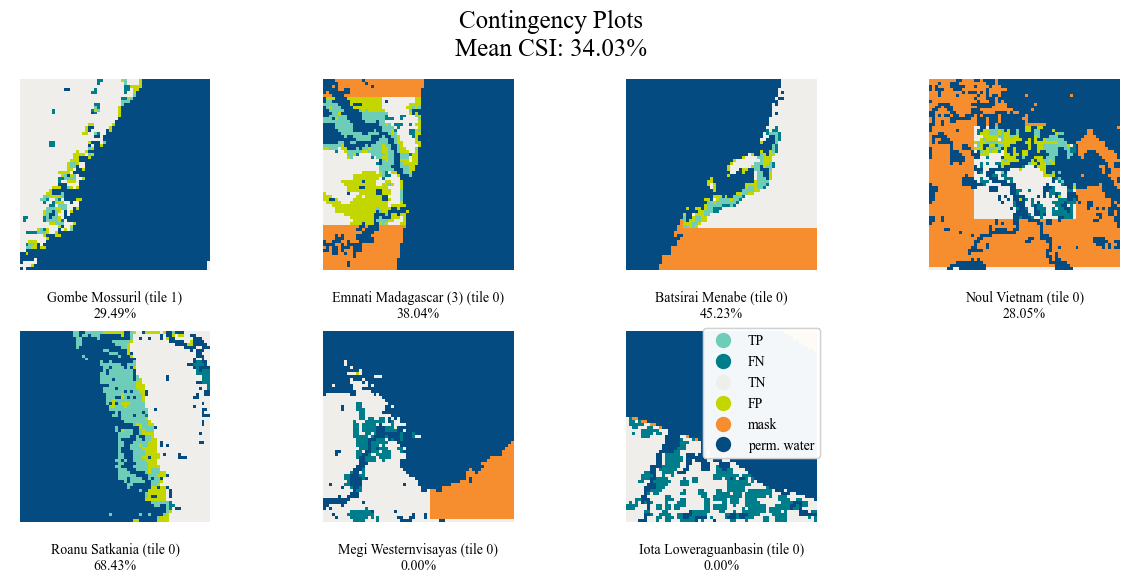

In [29]:
from matplotlib.lines import Line2D
plt.rcParams["font.family"] = "Times New Roman"


# set colours
pwater_col = '#034b80'
mask_col = soge_colours['orange']
cmap_flood = {'Flood': soge_colours['light turquoise'],
              'No flood': soge_colours['beige']}

cmap_contingency = {'TP': soge_colours['light turquoise'],
             'FN': soge_colours['medium turquoise'],
             'TN': soge_colours['beige'],
             'FP': soge_colours['yellowish green'],
             'mask': mask_col,
             'perm. water': pwater_col
            }
cm_categories = ListedColormap([soge_colours['medium turquoise'],
                                soge_colours['yellowish green'],
                                soge_colours['beige'],
                                soge_colours['light turquoise']])

nevents = len(TEST_EVENTS)

nrows = (nevents - 1) // 4 + 1
ncols = 4 if nevents >= 4 else nevents
fig = plt.figure(figsize=(15, 3 * nrows))
gs = fig.add_gridspec(nrows, ncols)

for i, test_event in enumerate(TEST_EVENTS):
    ax = fig.add_subplot(gs[i // 4, i % 4])
    
    to_plot = gdf_test_unseen[gdf_test_unseen.event == test_event]

    # plot background
    gdf_orig[gdf_orig.event == test_event].plot(color=mask_col, ax=ax, zorder=0, label='mask')
    pwater[pwater.event == test_event].plot(color=pwater_col, ax=ax, zorder=1, label='permanent water')
    
    # plot contingency
    to_plot.plot(color=to_plot['error_type'].map(cmap_contingency), categorical=True,  # cmap=cm_categories,
                 legend=False, legend_kwds={'loc': 'upper left'}, ax=ax,
                 zorder=2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xlabel(f'{format_event_string(test_event)}\n{CSIs_test_unseen[i]:.2%}')
    
# add manual legend
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in cmap_contingency.values()]
leg_points = ax.legend(custom_points, cmap_contingency.keys())
ax.add_artist(leg_points)

# clean up
ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlabel(f'{format_event_string(test_event)}\n{CSIs_test_unseen[i]:.2%}')

fig.suptitle(f"Contingency Plots\nMean CSI: {CSI_test_unseen:.2%}",
                 fontsize=18);


# format output png and save
outpath = join(imdir, 'rf_spatial', RUNNAME, f'unseen_regions_contingency.png')
fig.savefig(outpath, bbox_inches='tight', dpi=500)

In [30]:
perc_flooded_unseen = np.mean(gdf_test_unseen['floodfrac'] == 'Flood')

In [31]:
! say finished

## Log the results

In [32]:
LOGTHISRUN = False

In [33]:
if LOGTHISRUN:
    # add to the metrics csv
    metrics_dict = {
        'date': runtime.strftime("%Y-%m-%d %Hh%Mm"),
        'runname': RUNNAME,
        'notes': [notes],
        'nevents': gdf_normalised['event'].nunique(),
        'nfeatures': nfeatures,
        'features': [[*features]],
        'test events': [[*TEST_EVENTS]],
        'nzeros': n0,
        'nones': n1,
        'folds': K,
        'SEED': SEED,
        'best_params': [best_params],
        'mean train CSI': np.mean(CSIs),
        'std train CSIs': np.std(CSIs),
        'test CSI (unseen)': CSI_test_unseen,
        'test bias (unseen)': bias_test_unseen,
        'test binary acc': acc_test_unseen,
        '%flood in unseen': perc_flooded_unseen,
        'impurity-based rankings': [[*mean_rankings.index]],
        'impurity-based scores': [mean_rankings.values],
        'perm-based rankings': [[*mean_pis.index]] if run_pis else "not done",
        'perm-based scores': [mean_pis.values] if run_pis else "not done",
        'results folder': outpath
    }

    all_metrics = pd.read_csv(join(wd, 'images', 'rf_spatial', 'metrics.csv')).astype(str)
    metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='columns', dtype='object').astype(str)
    new_metrics = all_metrics.append(metrics_df)
    new_metrics = new_metrics.drop_duplicates()
    new_metrics.to_csv(join(wd, 'images', 'rf_spatial', 'metrics.csv'), index=False)

In [34]:
new_metrics[['runname', 'mean train CSI',
             'std train CSIs',
             'test CSI (unseen)', 'test bias (unseen)',
             'test binary acc', '%flood in unseen']].tail(10)

NameError: name 'new_metrics' is not defined

In [ ]:
! say done

# Results Analysis

In [ ]:
image_kwargs = {'bbox_inches': 'tight', 'dpi': 400}

In [ ]:
unseen_csis = new_metrics['test CSI (unseen)'].astype(float).values
unseen_biases = new_metrics['test bias (unseen)'].astype(float).values
seen_csis = new_metrics['mean train CSI'].astype(float).values
perc_floods = new_metrics['%flood in unseen'].astype(float).values
index = [*range(len(unseen_csis))]

fig, axs = plt.subplots(1, 2, figsize=(8, 3))

ax = axs[0]
ax.plot(index, unseen_csis, label='unseen CSI')
ax.plot(index, seen_csis, label='train CSI')
ax.set_xlabel('Run number')
ax.set_ylabel('CSI')
ax.set_title('Progress');
ax.legend()

ax = axs[1]
ax.plot(index, unseen_biases, label='unseen CSI')
ax.set_xlabel('Run number')
ax.set_ylabel('Unseen bias')
ax.set_title('Progress');



In [ ]:
fig, ax = plt.subplots()

ax.scatter(perc_floods, unseen_csis) # HMMMM!
ax.set_ylabel('CSI (unseen test set)')
ax.set_xlabel('% flood in test set')

In [ ]:
gdf = gpd.read_file(join(wd, 'results', 'unseen test set', 'unseen_results.gpkg'))

TP = gdf[gdf['error_type'] == 'TP']
TN = gdf[gdf['error_type'] == 'TN']
FP = gdf[gdf['error_type'] == 'FP']
FN = gdf[gdf['error_type'] == 'FN']

## Feature distributions

In [ ]:
# histogram of different features
FEATURE = 'evi'

hist_kwargs = {'alpha': 0.8, 'density': True, 'bins': 20, 'linewidth': 0.3, 'edgecolor': 'grey'}

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

ax = axs[0]
ax.hist(TN[FEATURE], color=soge_colours['beige'], label='TN', **hist_kwargs)
ax.hist(FP[FEATURE], color=soge_colours['yellowish green'], label='FP', **hist_kwargs)
ax.hist(FN[FEATURE], color=soge_colours['medium turquoise'], label='FN', **hist_kwargs)
ax.hist(TP[FEATURE], color=soge_colours['light turquoise'], label='TP', **hist_kwargs)
ax.legend()
ax.set_title(f"{viz_utils.labels[FEATURE].capitalize()} distribution for four error types")
ax.set_xlabel('Data')
ax.set_ylabel('Frequency')

ax = axs[1]
ax.hist(gdf[FEATURE], color=soge_colours['orange'], label='All', **hist_kwargs)
ax.set_title(f"{viz_utils.labels[FEATURE].capitalize()} distribution overall")
ax.set_xlabel('Data')
ax.set_ylabel('Frequency')

plt.show()

fig.savefig(join(imdir, "rf_spatial", RUNNAME, f'distribution_{FEATURE}.png'), **image_kwargs)

## Boxplots

In [ ]:
# boxplots of features
FEATURE = 'wind_avg'

feat_arrs = []
feat_labs = []
colours = {'full unseen dataset': viz_utils.soge_colours['orange'],
          'TN': viz_utils.soge_colours['beige'],
          'FN': viz_utils.soge_colours['medium turquoise'],
          'FP': viz_utils.soge_colours['yellowish green'],
          'TP': viz_utils.soge_colours['light turquoise']
         }

# first entry is for entire dataset
feat_arrs.append([*gdf[FEATURE]])
feat_labs.append('full unseen dataset')

for error_type in sorted(gdf['error_type'].unique()):
    gdf_error_type = gdf[gdf['error_type'] == error_type]
    feat_arrs.append([*gdf_error_type[FEATURE]])
    feat_labs.append(error_type)
    
colours = [colours[x] for x in feat_labs]
    
# plot
fig, ax = plt.subplots(figsize=(20, 10))

bp = ax.boxplot(feat_arrs, vert=False, patch_artist=True);
ax.set_title(viz_utils.labels[FEATURE].capitalize())
ax.set_yticklabels(feat_labs, rotation=0, fontsize=12, va='center')

for patch, colour in zip(bp['boxes'], colours):
    patch.set_facecolor(colour)
    patch.set_alpha(0.8)
    patch.set_edgecolor('darkgrey')

# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='.',
              color ='blue',
              alpha = 0.5,
              markersize=0.1)
    
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='black',
                linewidth = 1.5,
                linestyle =":")

# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='black',
            linewidth = 2)
    
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='black',
               linewidth = 3)
    
fig.savefig(join(imdir, "rf_spatial", RUNNAME, f'error_distributions_{FEATURE}.png'), **image_kwargs)

## Flood types

In [ ]:
LEVEL = '8'

def parse_event(event):
    split = event.split('_')
    storm = split[0]
    sub = split[2]
    if len(split) == 3:
        region = split[1]
    elif len(split) == 4:
        region = '_'.join([split[1], split[3]])
    else:
        return np.nan
    return storm, region, sub
    
gdf = gpd.read_file(join(wd, 'results', 'unseen test set', 'unseen_results.gpkg'))
gdf[['storm', 'region', 'subregion']] = pd.DataFrame(gdf['event'].apply(lambda x: parse_event(x)).to_list())

metadata = pd.read_csv(join(wd, 'csvs', 'current_datasets.csv'), index_col=['event', 'region'])

gdf['continent'] = gdf.apply(lambda row: metadata.loc[(row['storm'], row['region'])]['continent'], axis=1)

events = []
for event in gdf['event'].unique():
    gdf_event = gdf[gdf['event'] == event]
    continent = gdf_event.continent.mode()[0]
    hydrobasins = gpd.read_file(join(wd, 'hydrobasin', f'hybas_{continent}_lev01-12_v1c', f'hybas_{continent}_lev{LEVEL.zfill(2)}_v1c.shp'),
                               mask=gdf_event)
    gdf_event_type = gpd.overlay(gdf_event, hydrobasins[['COAST', 'geometry']], how='intersection')
    events.append(gdf_event_type)

gdf = pd.concat(events)
TP = gdf[gdf['error_type'] == 'TP']
TN = gdf[gdf['error_type'] == 'TN']
FP = gdf[gdf['error_type'] == 'FP']
FN = gdf[gdf['error_type'] == 'FN']

In [ ]:
FEATURE = 'COAST'

hist_kwargs = {'alpha': 0.8, 'density': False, 'bins': 2, 'linewidth': 0.3, 'edgecolor': 'grey'}


fig, axs = plt.subplots(1, 2, figsize=(10, 3))
ax = axs[0]

ax.hist([TN[FEATURE], FP[FEATURE], FP[FEATURE], TP[FEATURE]],
        color=[soge_colours['beige'], soge_colours['yellowish green'], soge_colours['medium turquoise'], soge_colours['light turquoise']],
        label=['TN', 'TP', 'FP', 'TP'],
        **hist_kwargs)

ax.legend()

ax.set_title(f"{viz_utils.labels[FEATURE].capitalize()} counts for four error types")
ax.set_xlabel('Data')
ax.set_ylabel('Count')
ax.set_xticks([0.25, 0.75])
ax.set_xticklabels(['inland', 'coastal'])

ax = axs[1]
ax.hist(gdf[FEATURE], color=soge_colours['orange'], label='All', **hist_kwargs)
ax.set_title(f"{viz_utils.labels[FEATURE].capitalize()} counts overall")
ax.set_xticks([0.25, 0.75])
ax.set_xticklabels(['inland', 'coastal'])
ax.set_xlabel('Data')
ax.set_ylabel('Count')

plt.show()

fig.savefig(join(imdir, "rf_spatial", RUNNAME, f'floodtype_{FEATURE}.png'), **image_kwargs)

# Hyperparameter Tuning (Optional)
## 1. Random CV
From [this tutorial](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74).

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# set up random grid search
randomcv = False

# look at base case
SEED = 1
rf = RandomForestClassifier(random_state=SEED)

# train-test split
X, y = gdf_normalised[features], gdf_normalised['flood']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)

if randomcv:
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]


    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    pprint(random_grid)
    
    rf = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100,
                                   cv=3, scoring=csi_scorer, verbose=2, random_state=42, n_jobs=-1)

    rf_random.fit(X_train, y_train)
    print(rf_random.best_params_)
    
    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)
    grid_search.best_params_

    np.save('best_params_rf.npy', grid_search.best_params_) 
    
    
    base_model = RandomForestClassifier(random_state=SEED)
    base_model.fit(X_train, y_train)
    base_csi = evaluate(base_model, X_test, y_test)

    best_random = grid_search.best_estimator_
    random_csi = evaluate(best_random, X_test, y_test)

    print('Improvement of {:0.2f}%.'.format( 100 * (random_csi - base_csi) / base_csi))

    !say done

## 2. Grid Search

In [ ]:
gridsearch = False

if gridsearch:
    from sklearn.model_selection import GridSearchCV
    # Create the parameter grid based on the results of random search 
    param_grid = {
        'bootstrap': [False],
        'max_depth': [40, 45, 50, 55, 60],
        'max_features': ['auto'],
        'min_samples_leaf': [1, 2, 3],
        'min_samples_split': [1, 2, 3],
        'n_estimators': [500, 1000, 1500]
    }

    # Create a based model
    rf = RandomForestClassifier(random_state=SEED)
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring=csi_scorer, 
                              cv=3, n_jobs=-1, verbose=2)
    
    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)
    grid_search.best_params_

    np.save('best_params_rf.npy', grid_search.best_params_) 